In [1]:
import numpy as np
from core import utils, geodesics, generative_models, manifolds
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
from sklearn.metrics import pairwise_distances

In this example we replace the Euclidean metric of the ambient space with a user defined Riemannian metric that allows to encode high-level information.

In [2]:
# Generate the data
params = {'N': 2000, 'data_type': 3, 'sigma': 0.1, 'extra_dims': 2}
data, labels = utils.generate_data(params)

Text(0.5, 0.92, 'Only the signal in the data')

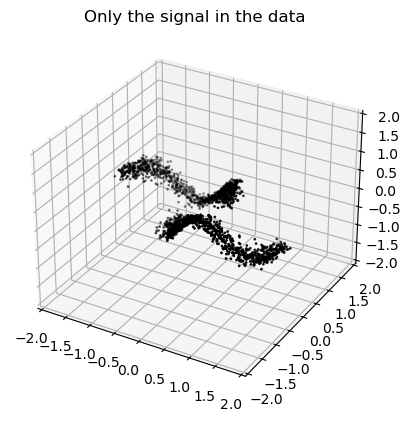

In [3]:
# Plot the data
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='k', s=1)
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])
plt.title('Only the signal in the data')

In [4]:
# The parameters of the model
d = 2  # The latent space dimension
N_data, D = data.shape
activFunName = 'tanh'  # tanh used in the synthetics
activations_list = {
    'softplus': torch.nn.Softplus(),
    'tanh': torch.nn.Tanh()
}
activFun = activations_list[activFunName]
H = 32
lambda_reg = 1e-8  # For the weights of the networks
epochs = 500
learning_rate = 1e-3  # 0.0001 works for MNIST and 0.1 for the synthetic
clipping_value = 1
batch_size = 128
warmup = int(0.35 * epochs)

In [5]:
# Use PCA to get the linear extrapolation
A_gen, L_gen, b_gen = utils.my_pca(data, d)
A_gen = A_gen @ np.diag(np.sqrt(L_gen))  # Project based on Probabilistic PCA: N(0, 1) -> data

In [6]:
# Construct the VAE
VAE_model = generative_models.VariationalAutoEncoder_GELS(D=D, d=d, H=H, activFun=activFun, A_init=A_gen, b_init=b_gen)
VAE_optimizer = torch.optim.Adam(VAE_model.parameters(), lr=learning_rate)

In [7]:
# Train the VAE
ELBO = np.zeros((epochs, 1))
for epoch in range(epochs):
    # Permute the indices of the train data
    permutation = np.random.permutation(N_data)
    train_loss = 0
    train_loss_num = 0
    # Train for all the batches
    for i in range(0, N_data, batch_size):
        indices = permutation[i:i + batch_size]
        X_batch = torch.from_numpy(data[indices, :].astype(np.float32)) # batch_indices x D

        # The VAE
        MU_X_eval, LOG_VAR_X_eval, Z_ENC_eval, MU_Z_eval, LOG_VAR_Z_eval = VAE_model(X_batch)

        # Compute the regularization parameter
        if warmup == 0:
            r = 0
        else:
            r = 1. * epoch / warmup
            if r > 1.:
                r = 1.

        loss = generative_models.VAE_loss_GELS(x=X_batch, mu_x=MU_X_eval, log_var_x=LOG_VAR_X_eval,
                                               mu_z=MU_Z_eval, log_var_z=LOG_VAR_Z_eval, anneal_param=r)

        # Update the parameters
        VAE_optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)
        VAE_optimizer.step()
        # Collect the ways
        train_loss += loss.item()
        train_loss_num += 1

    ELBO[epoch] = train_loss / train_loss_num

    if epoch % 20 == 0:
        print("[Epoch: {}/{}] [objective: {:.3f}]".format(epoch, epochs, ELBO[epoch, 0]))


[Epoch: 0/500] [objective: 0.461]
[Epoch: 20/500] [objective: -10.074]
[Epoch: 40/500] [objective: -10.008]
[Epoch: 60/500] [objective: -9.733]
[Epoch: 80/500] [objective: -9.134]
[Epoch: 100/500] [objective: -8.207]
[Epoch: 120/500] [objective: -7.032]
[Epoch: 140/500] [objective: -6.049]
[Epoch: 160/500] [objective: -5.111]
[Epoch: 180/500] [objective: -4.392]
[Epoch: 200/500] [objective: -4.393]
[Epoch: 220/500] [objective: -4.410]
[Epoch: 240/500] [objective: -4.430]
[Epoch: 260/500] [objective: -4.480]
[Epoch: 280/500] [objective: -4.491]
[Epoch: 300/500] [objective: -4.437]
[Epoch: 320/500] [objective: -4.527]
[Epoch: 340/500] [objective: -4.462]
[Epoch: 360/500] [objective: -4.507]
[Epoch: 380/500] [objective: -4.412]
[Epoch: 400/500] [objective: -4.469]
[Epoch: 420/500] [objective: -4.473]
[Epoch: 440/500] [objective: -4.492]
[Epoch: 460/500] [objective: -4.469]
[Epoch: 480/500] [objective: -4.531]


In [8]:
ELBO_train = ELBO[epoch, 0].round(2)  # THe final training ELBO
with torch.no_grad():
    MU_X_data, LOG_VAR_X_data, _, MU_Z_data, LOG_VAR_Z_data = VAE_model(torch.from_numpy(data.astype(np.float32)))
    MU_X_data = MU_X_data.detach().numpy()
    VAR_X_data = LOG_VAR_X_data.exp().detach().numpy()
    MU_Z_data = MU_Z_data.detach().numpy()
    VAR_Z_data = LOG_VAR_Z_data.exp().detach().numpy()

In [9]:
# Plot the results, only the first 3 dims is the signal
ax.scatter(MU_X_data[:, 0], MU_X_data[:, 1], MU_X_data[:, 2], c='r', s=1)

Text(0.5, 1.0, 'Latent space')

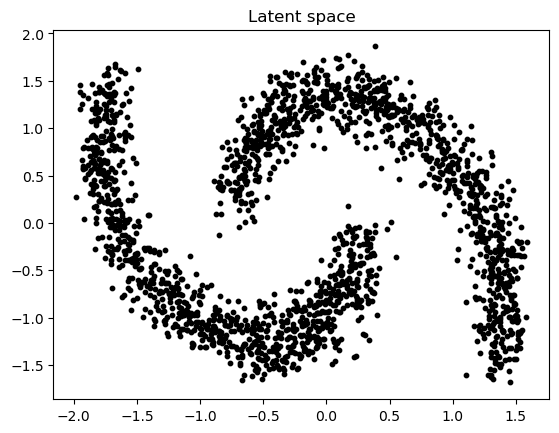

In [10]:
plt.figure()
plt.scatter(MU_Z_data[:, 0], MU_Z_data[:, 1], c='k', s=10)
plt.title('Latent space')

Text(0.5, 1.0, 'Training ELBO')

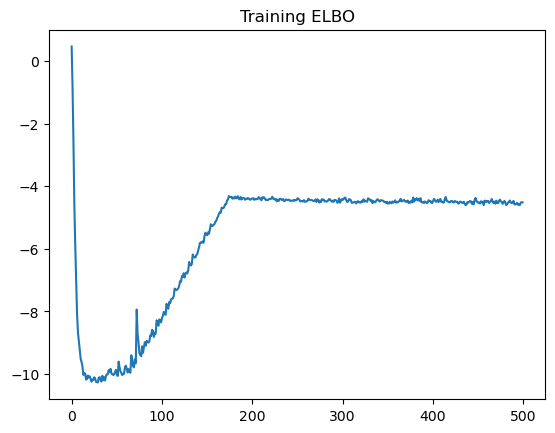

In [11]:
plt.figure()
plt.plot(ELBO)
plt.title('Training ELBO')

In [12]:
# Construct the manifold
# The RBF parameters
alpha_rbf = 1000 * np.sqrt(VAR_X_data).mean()  # USER CHOICE: the maximum std
zeta_rbf = 1 / (alpha_rbf ** 2)

In [13]:
# Fit offline the RBF network for meaningful uncertainty estimates
K_rbf = 100  # Number of rbf centers
W_rbf = torch.rand(D, K_rbf, requires_grad=True)  # The rbf weights
kMeans_model = KMeans(n_clusters=K_rbf, n_init=30, max_iter=1000).fit(MU_Z_data)
Labels_rbf = kMeans_model.labels_
optimizer_rbf = torch.optim.Adam(list([W_rbf]), lr=1e-1)

In [14]:
# The centers and the bandwidths initialization
G_rbf = np.zeros((K_rbf, 1))
C_rbf = kMeans_model.cluster_centers_

In [15]:
# Bandwidth selection: minimum of the diagonal of the covariance matrix of each cluster
Sigmas = np.zeros((K_rbf, 1))
for k in range(K_rbf):
    inds_k = (Labels_rbf == k)
    points = MU_Z_data[inds_k, :]
    c_k = C_rbf[k, :].reshape(-1, 1)
    S = (np.diag((points - c_k.T).T @ (points - c_k.T))/points.shape[0]).min()
    Sigmas[k, 0] = np.sqrt(S)

In [16]:
Sigmas = 1.5 * Sigmas  # Increase the Sigma by a global factor to smooth out the metric
G_rbf = 0.5 / (Sigmas ** 2)

G_rbf = torch.from_numpy(G_rbf.astype(np.float32))
C_rbf = torch.from_numpy(C_rbf.astype(np.float32))

In [17]:
# The precision function
def gamma(Z):
    # Z: batch_size x d
    gamma_res = torch.exp(-utils.pairwise_dist2_torch(Z, C_rbf) * G_rbf.T) @ W_rbf.T + zeta_rbf
    return gamma_res

In [18]:
iters = 10000
TEMP_LOSS = np.zeros((iters, 1))
batch_size_rbf = 512
for iter in range(iters):
    permutation = np.random.permutation(N_data)

    temp_loss = 0
    temp_loss_num = 0
    for i in range(0, N_data, batch_size_rbf):
        indices = permutation[i:i + batch_size_rbf]
        LOG_VAR_X_data_batch = LOG_VAR_X_data[indices, :]  # batch_indices x D
        MU_Z_data_batch = torch.from_numpy(MU_Z_data[indices, :].astype(np.float32))  # batch_indices x D
        LOG_VAR_X_eval = -torch.log(gamma(MU_Z_data_batch))
        loss = ((LOG_VAR_X_data_batch - LOG_VAR_X_eval) ** 2).sum(1).mean(0)

        # Update the parameters
        optimizer_rbf.zero_grad()
        loss.backward()
        optimizer_rbf.step()
        W_rbf.data.clamp_(min=1e-5)
        temp_loss += loss.item()
        temp_loss_num += 1

    TEMP_LOSS[iter, 0] = temp_loss / temp_loss_num
    if iter % 100 == 0:
        print("[RBF training] [Iter: {}/{}] [objective: {:.3f}]"
              .format(iter, iters, TEMP_LOSS[iter, 0]))

[RBF training] [Iter: 0/10000] [objective: 210.540]
[RBF training] [Iter: 100/10000] [objective: 64.198]
[RBF training] [Iter: 200/10000] [objective: 49.462]
[RBF training] [Iter: 300/10000] [objective: 41.452]
[RBF training] [Iter: 400/10000] [objective: 35.998]
[RBF training] [Iter: 500/10000] [objective: 31.876]
[RBF training] [Iter: 600/10000] [objective: 28.591]
[RBF training] [Iter: 700/10000] [objective: 25.885]
[RBF training] [Iter: 800/10000] [objective: 23.544]
[RBF training] [Iter: 900/10000] [objective: 21.540]
[RBF training] [Iter: 1000/10000] [objective: 19.726]
[RBF training] [Iter: 1100/10000] [objective: 18.118]
[RBF training] [Iter: 1200/10000] [objective: 16.632]
[RBF training] [Iter: 1300/10000] [objective: 15.288]
[RBF training] [Iter: 1400/10000] [objective: 14.096]
[RBF training] [Iter: 1500/10000] [objective: 12.986]
[RBF training] [Iter: 1600/10000] [objective: 11.951]
[RBF training] [Iter: 1700/10000] [objective: 11.020]
[RBF training] [Iter: 1800/10000] [obje

In [19]:
with torch.no_grad():
    C_rbf_data = C_rbf.detach().numpy()
    W_rbf_data = W_rbf.detach().numpy()
    G_rbf_data = G_rbf.detach().numpy()

In [20]:
# Construct the pull-back metric
for name, param in VAE_model.named_parameters():
    print('name: ', name)
    print(type(param))
    print('param.shape: ', param.shape)
    print('param.requires_grad: ', param.requires_grad)
    # print(param)
    print('=============================================')

name:  mu_enc.0.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([64, 5])
param.requires_grad:  True
name:  mu_enc.0.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([64])
param.requires_grad:  True
name:  mu_enc.2.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([32, 64])
param.requires_grad:  True
name:  mu_enc.2.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([32])
param.requires_grad:  True
name:  mu_enc.4.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([2, 32])
param.requires_grad:  True
name:  mu_enc.4.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([2])
param.requires_grad:  True
name:  log_var_enc.0.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([64, 5])
param.requires_grad:  True
name:  log_var_enc.0.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([64])
param.requires_grad:  True
name:  log_var_enc.2.weigh

In [21]:
G_model_parameters = {'name': 'generator'}
w_counter = 0
b_counter = 0
# The weights appear sequentially as in the model definition
for name, param in VAE_model.named_parameters():
    if 'dec_resNet' in name:
        if 'weight' in name:
            key_name = 'A_gen'
            G_model_parameters[key_name] = param.detach().numpy()
            # w_counter += 1
        elif 'bias' in name:
            key_name = 'b_gen'
            G_model_parameters[key_name] = param.detach().numpy().reshape(-1, 1)
            # b_counter += 1
    elif 'mu_dec' in name:
        if 'weight' in name:
            key_name = 'W' + str(w_counter)
            G_model_parameters[key_name] = param.detach().numpy()
            w_counter += 1
        elif 'bias' in name:
            key_name = 'b' + str(b_counter)
            G_model_parameters[key_name] = param.detach().numpy().reshape(-1, 1)
            b_counter += 1

G_model_parameters['activation_fun_hidden'] = str(activFunName).lower()  # Get the name of activFun e.g. Tanh() -> tanh
G_model_parameters['activation_fun_output'] = 'linear'  # tanh / sigmoid /
G_model_parameters['Wrbf'] = W_rbf_data  # The weights for the RBFs (D x K)
G_model_parameters['Crbf'] = C_rbf_data  # The centers for the RBFs (K x d)
G_model_parameters['Grbf'] = G_rbf_data  # * np.ones((K_rbf, 1))  # The precision for the RBFs (K x 1)
G_model_parameters['zeta'] = zeta_rbf  # A small value to prevent division by 0
G_model_parameters['beta'] = 1.0  # A scaling parameter for the metric beta * M(z)

In [22]:
# If we project the data into a lower dimensional "ambient space" to construct therein the "ambient metric"
with_projection = True
d_prime = 3
A_prime, L_prime, b_prime = utils.my_pca(data, d_prime)  # Project linearly the data to a lower dimensional space
A_prime = A_prime @ np.diag(1 / L_prime)  # Whiten the data
G_model_parameters['with_projection'] = with_projection  # If we use linear projection
G_model_parameters['A_proj'] = A_prime.T  # D x d' -> d' x D
G_model_parameters['b_proj'] = b_prime

In [23]:
# Construct a meshgrid to plot latent metrics
z1min, z2min = MU_Z_data.min(0) - 0.5
z1max, z2max = MU_Z_data.max(0) + 0.5
N_Z_grid = 30
Z_grid = utils.my_meshgrid(z1min, z1max, z2min, z2max, N=N_Z_grid)

In [24]:
# The maximum and minimum measure to have the same bound for all examples
Measure_min = 0
Measure_max = 20

Text(0.5, 1.0, 'Pullback of Euclidean metric')

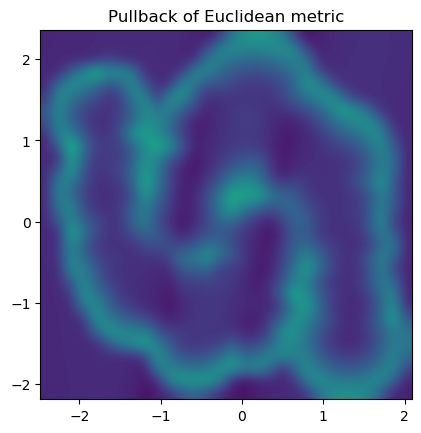

In [25]:
# Construct the pull-back metric using the Euclidean as the ambient metric
manifold_ambient_euclidean = manifolds.EuclideanAmbient(D=d_prime)  # The Euclidean metric of the projected space
G_model_parameters['manifold_ambient'] = manifold_ambient_euclidean
manifold_latent_euclidean = manifolds.ManifoldPullBack(G_model_parameters)
Measure_amb_euclidean = manifold_latent_euclidean.measure(Z_grid.T)
plt.figure()
plt.imshow(np.log(Measure_amb_euclidean).reshape(N_Z_grid, N_Z_grid), interpolation='bicubic',
           extent=(z1min, z1max, z2min, z2max), origin='lower', vmin=Measure_min, vmax=Measure_max)
plt.title('Pullback of Euclidean metric')


Text(0.5, 1.0, 'Pullback of LocalPCA metric')

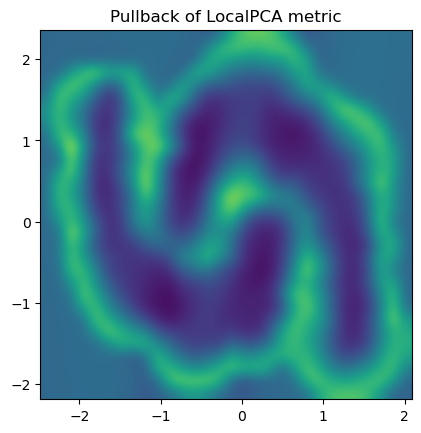

In [26]:
# The Local Diagonal PCA metric
sigma_amb_pca = 0.3
rho_amb_pca = 1e-2
manifold_ambient_pca = manifolds.LocalDiagPCA(data=data, sigma=sigma_amb_pca, rho=rho_amb_pca,
                                          with_projection=with_projection, A=A_prime, b=b_prime)
G_model_parameters['manifold_ambient'] = manifold_ambient_pca
manifold_latent_pca = manifolds.ManifoldPullBack(G_model_parameters)
Measure_amb_pca = manifold_latent_pca.measure(Z_grid.T)
plt.figure()
plt.imshow(np.log(Measure_amb_pca).reshape(N_Z_grid, N_Z_grid), interpolation='bicubic',
           extent=(z1min, z1max, z2min, z2max), origin='lower', vmin=Measure_min, vmax=Measure_max)
plt.title('Pullback of LocalPCA metric')

In [27]:
# The LDA metric
# Select the number of points with labels in case of a semi-supervised setting.
N_data_lda = N_data  # How many points from the data to use for their labels
inds_lda = np.random.choice(N_data, N_data_lda, replace=False)
X_data_lda = data[inds_lda, :]
Y_data_lda = labels[inds_lda, :]

In [28]:
# If projection is used project also the data to construct the LDA metric
if with_projection:
    X_data_lda = ((X_data_lda - b_prime.T) @ A_prime)  # N x D -> N x d'
D_lda = X_data_lda.shape[1]

In [29]:
N_centers = 1000  # Number of base points to learn LDA metrics

In [30]:
# This constructs a 'grid' for the latent codes
# Construct a uniform distribution to cover the latent codes and then use k-means on that.
Uniform_data = MU_Z_data.min(0) + (MU_Z_data.max(0) - MU_Z_data.min(0)) * np.random.rand(4000, 2)
X_centers = KMeans(n_clusters=N_centers, max_iter=1000).fit(Uniform_data).cluster_centers_
with torch.no_grad():
    X_centers = VAE_model.decode(torch.from_numpy(X_centers.astype(np.float32)))[0].detach().numpy()
if with_projection:
    X_centers = ((X_centers - b_prime.T) @ A_prime)  # N x D -> N x d'

/Users/fabrizioloscudo/miniconda3/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [31]:
# The number of kNN for each center to use their labels for the LDA metric.
N_knn = 50

N_classes_lda = np.unique(labels).shape[0]
Class_labels_lda = np.unique(labels)
Metrics_lda = np.eye(D_lda)
Metrics_lda = Metrics_lda[None, :].repeat(N_centers, axis=0)  # N x D x D
sigmas_per_center = np.zeros((N_centers, 1))
epsilon_reg_lda = 0.001  # The epsilon to avoid degenerated metrics

In [32]:
# Construct for each center center the local LDA metric using the kNN's labels
for n in range(50):
    print('Magnitude of LDA metrics: ' + str(np.linalg.det(Metrics_lda).mean()))

    for k in range(N_centers):
        dists_k = pairwise_distances(X_centers[k, :].reshape(1, -1), X_data_lda,
                                     metric='mahalanobis', VI=Metrics_lda[k, :, :]).reshape(-1, 1)
        knn_inds_k = np.argsort(dists_k.flatten())[:N_knn]  # The kNN for the center
        dists_knn_k = dists_k[knn_inds_k, 0].reshape(-1, 1)
        sigmas_per_center_k = np.max(dists_knn_k) + 0.01  # The maximum distance among the kNNs
        sigmas_per_center[k] = sigmas_per_center_k
        weights_knn = (1 - (dists_knn_k / sigmas_per_center_k)**3)**3  # The weights for the kNNs

        X_k_knn = X_data_lda[knn_inds_k, :]  # The kNN points of the center k
        Y_k_knn = Y_data_lda[knn_inds_k, :]  # The labels of the kNNs of the center k

        # The weighted mean of the kNN
        X_k_knn_mean = weights_knn.T @ X_k_knn / weights_knn.sum()

        W = np.zeros((D_lda, D_lda))  # Initialize the within matrix
        B = np.zeros((D_lda, D_lda))  # Initialize the in-between matrix

        for class_k in range(N_classes_lda):
            inds_k = (Y_k_knn == Class_labels_lda[class_k])  # The indices of the points from class_k in the kNNs

            # If there are not enough instances of class_k in the kNN of the center
            if not np.sum(inds_k) > 1:
                continue

            X_k_knn_class_k = X_k_knn[inds_k.flatten(), :]  # The points of class_k in the kNN of the center
            weights_knn_class_k = weights_knn[inds_k.flatten(), :].reshape(-1, 1)  # The weights of the points

            # The weighted mean of the class_k points and center the points of the class_k accordingly
            X_k_knn_class_k_mean = weights_knn_class_k.T @ X_k_knn_class_k / weights_knn_class_k.sum()
            X_k_knn_class_k_centered = X_k_knn_class_k - X_k_knn_class_k_mean.reshape(1, -1)

            # Compute within and between matrices
            W = W + X_k_knn_class_k_centered.T @ np.diag(weights_knn_class_k.flatten()) @ X_k_knn_class_k_centered / weights_knn.sum()
            B = B + (weights_knn_class_k.sum() / weights_knn.sum()) * \
                (X_k_knn_class_k_mean - X_k_knn_mean) * (X_k_knn_class_k_mean - X_k_knn_mean).T

        inv_diag_W = np.linalg.inv(np.diag(np.diag(W)))  # Use the diagonal of the within matric only
        Metrics_lda[k, :, :] = inv_diag_W @ B @ inv_diag_W + epsilon_reg_lda * inv_diag_W

Magnitude of LDA metrics: 1.0
Magnitude of LDA metrics: 0.13037318704296147
Magnitude of LDA metrics: 0.0566287483520764
Magnitude of LDA metrics: 0.01778568985660033
Magnitude of LDA metrics: 0.013413363932107078
Magnitude of LDA metrics: 0.020055060533623045
Magnitude of LDA metrics: 0.015192288372777267
Magnitude of LDA metrics: 0.013173353348491519
Magnitude of LDA metrics: 0.007967617689670227
Magnitude of LDA metrics: 0.004537005593761617
Magnitude of LDA metrics: 0.0035383553960734305
Magnitude of LDA metrics: 0.0169776273559661
Magnitude of LDA metrics: 0.004878522581643587
Magnitude of LDA metrics: 0.005792616328557926
Magnitude of LDA metrics: 0.003770717883887438
Magnitude of LDA metrics: 0.005677339134040354
Magnitude of LDA metrics: 0.008919639637210977
Magnitude of LDA metrics: 0.008393737665422972
Magnitude of LDA metrics: 0.00521257223124249
Magnitude of LDA metrics: 0.006356207813181781
Magnitude of LDA metrics: 0.004493620143472961
Magnitude of LDA metrics: 0.00869658

In [33]:
M_nan_inds = np.isnan(Metrics_lda[:, 0, 0])  # The LDA metrics that failed computed
M_lda = Metrics_lda[(M_nan_inds == False).flatten(), :, :]  # The local LDA metrics
X_lda = X_centers[(M_nan_inds == False).flatten(), :]  # The centers of the local LDA metric

Text(0.5, 1.0, 'Pullback of LDA metric')

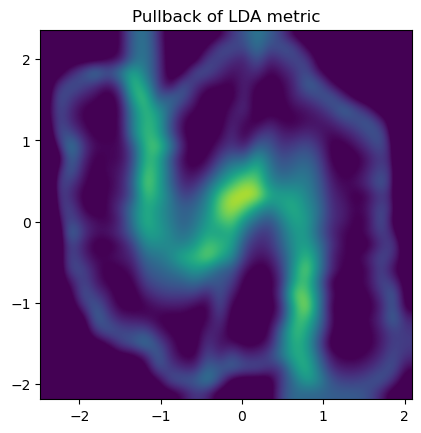

In [34]:
# Construct the LDA ambient metric
sigma_lda = 0.4
manifold_ambient_lda = manifolds.WeightedAverageMetrics(X=X_lda, M=M_lda, sigma=sigma_lda,
                                                    with_projection=with_projection, A=A_prime, b=b_prime)
G_model_parameters['manifold_ambient'] = manifold_ambient_lda
manifold_latent_lda = manifolds.ManifoldPullBack(G_model_parameters)
Measure_amb_lda = manifold_latent_lda.measure(Z_grid.T)
plt.figure()
plt.imshow(np.log(Measure_amb_lda).reshape(N_Z_grid, N_Z_grid), interpolation='bicubic',
           extent=(z1min, z1max, z2min, z2max), origin='lower', vmin=Measure_min, vmax=Measure_max)
plt.title('Pullback of LDA metric')

Text(0.5, 1.0, 'Pullback of Cost metric')

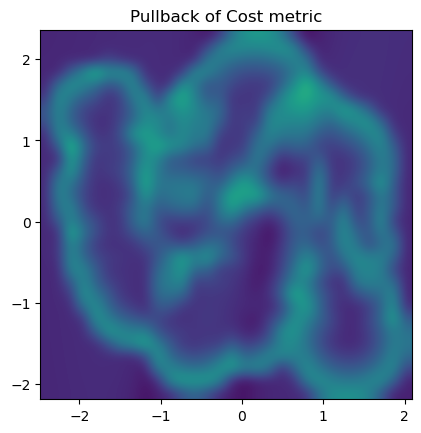

In [35]:
# Construct a cost metric
# Select some random points to increase the cost around them
N_cost_points = 10
manifold_ambient_cost = manifolds.ExponentialRBFCostFunction(data[np.random.choice(N_data, N_cost_points, replace=False), :],
                                                         W=1000 * np.ones((N_cost_points, 1)),
                                                         sigma=0.3, rho=1,
                                                         with_projection=with_projection, A=A_prime, b=b_prime)
G_model_parameters['manifold_ambient'] = manifold_ambient_cost
manifold_latent_cost = manifolds.ManifoldPullBack(G_model_parameters)
Measure_amb_cost = manifold_latent_cost.measure(Z_grid.T)
plt.figure()
plt.imshow(np.log(Measure_amb_cost).reshape(N_Z_grid, N_Z_grid), interpolation='bicubic',
           extent=(z1min, z1max, z2min, z2max), origin='lower', vmin=Measure_min, vmax=Measure_max)
plt.title('Pullback of Cost metric')

Text(0.5, 1.0, 'Cost')

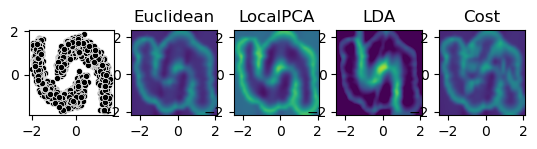

In [36]:

# Plot all the metrics together
plt.figure()
plt.subplot(1, 5, 1)
plt.scatter(MU_Z_data[:, 0], MU_Z_data[:, 1], s=20, c='k', linewidths=0.5, edgecolors='w')
plt.axis('image')
plt.subplot(1, 5, 2)
plt.imshow(np.log(Measure_amb_euclidean).reshape(N_Z_grid, N_Z_grid), interpolation='bicubic',
           extent=(z1min, z1max, z2min, z2max), origin='lower', vmin=Measure_min, vmax=Measure_max)
plt.title('Euclidean')
plt.subplot(1, 5, 3)
plt.imshow(np.log(Measure_amb_pca).reshape(N_Z_grid, N_Z_grid), interpolation='bicubic',
           extent=(z1min, z1max, z2min, z2max), origin='lower', vmin=Measure_min, vmax=Measure_max)
plt.title('LocalPCA')
plt.subplot(1, 5, 4)
plt.imshow(np.log(Measure_amb_lda).reshape(N_Z_grid, N_Z_grid), interpolation='bicubic',
           extent=(z1min, z1max, z2min, z2max), origin='lower', vmin=Measure_min, vmax=Measure_max)
plt.title('LDA')
plt.subplot(1, 5, 5)
plt.imshow(np.log(Measure_amb_cost).reshape(N_Z_grid, N_Z_grid), interpolation='bicubic',
           extent=(z1min, z1max, z2min, z2max), origin='lower', vmin=Measure_min, vmax=Measure_max)
plt.title('Cost')

In [38]:
# Compute geodesics
N_points = 4  # Subsample the latent codes
POINTS = KMeans(n_clusters=N_points, max_iter=1000).fit(MU_Z_data).cluster_centers_

/Users/fabrizioloscudo/miniconda3/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [39]:
# Use the graph solver
# solver_bvp = utils.SolverBVP(tol=1e-1, NMax=100)
N_nodes = 20
GRAPH_DATA = KMeans(n_clusters=N_nodes, n_init=30, max_iter=1000).fit(MU_Z_data).cluster_centers_

In [40]:
solver_graph_latent_euclidean = geodesics.SolverGraph(manifold=manifold_latent_euclidean, data=GRAPH_DATA, kNN_num=int(np.log(N_nodes)), tol=1e-2)
solver_graph_latent_pca = geodesics.SolverGraph(manifold=manifold_latent_pca, data=GRAPH_DATA, kNN_num=int(np.log(N_nodes)), tol=1e-2)
solver_graph_latent_lda = geodesics.SolverGraph(manifold=manifold_latent_lda, data=GRAPH_DATA, kNN_num=int(np.log(N_nodes)), tol=1e-2)
solver_graph_latent_cost = geodesics.SolverGraph(manifold=manifold_latent_cost, data=GRAPH_DATA, kNN_num=int(np.log(N_nodes)), tol=1e-2)

[Initialize Graph] [Processed point: 0/20]
[Initialize Graph] [Processed point: 0/20]
[Initialize Graph] [Processed point: 0/20]
[Initialize Graph] [Processed point: 0/20]


In [41]:
Dists_euclidean = np.zeros((N_points, N_points))
Dists_pca = np.zeros((N_points, N_points))
Dists_lda = np.zeros((N_points, N_points))
Dists_cost = np.zeros((N_points, N_points))

for n1 in range(N_points):
    for n2 in range(n1 + 1, N_points):
        c0 = POINTS[n1, :].reshape(-1, 1)
        c1 = POINTS[n2, :].reshape(-1, 1)

        _, _, curve_length_euclidean, _, _ \
            = geodesics.compute_geodesic(solver_graph_latent_euclidean, manifold_latent_euclidean, c0, c1)
        _, _, curve_length_pca, _, _ \
            = geodesics.compute_geodesic(solver_graph_latent_pca, manifold_latent_pca, c0, c1)
        _, _, curve_length_lda, _, _ \
            = geodesics.compute_geodesic(solver_graph_latent_lda, manifold_latent_lda, c0, c1)
        _, _, curve_length_cost, _, _ \
            = geodesics.compute_geodesic(solver_graph_latent_cost, manifold_latent_cost, c0, c1)

        Dists_euclidean[n1, n2] = curve_length_euclidean
        Dists_pca[n1, n2] = curve_length_pca
        Dists_lda[n1, n2] = curve_length_lda
        Dists_cost[n1, n2] = curve_length_cost

In [42]:
Res_euclidean = Dists_euclidean[np.triu_indices(N_points, k=1)]
Res_pca = Dists_pca[np.triu_indices(N_points, k=1)]
Res_lda = Dists_lda[np.triu_indices(N_points, k=1)]
Res_cost = Dists_cost[np.triu_indices(N_points, k=1)]

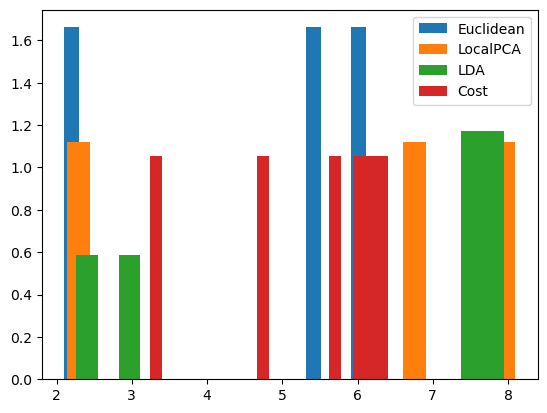

In [43]:
plt.figure()
plt.hist(np.log(Res_euclidean), bins=20, density=True, label='Euclidean')
plt.hist(np.log(Res_pca), bins=20, density=True, label='LocalPCA')
plt.hist(np.log(Res_lda), bins=20, density=True, label='LDA')
plt.hist(np.log(Res_cost), bins=20, density=True, label='Cost')
plt.legend()

In [44]:
print('Euclidean: distances increase when paths change cluster.')
print('LocalPCA: distances shorten within cluster and increase more when paths change cluster.')
print('LDA: distances shorten within cluster and increase more when paths change cluster.')
print('Cost: distances increase within clusters as there are costly regions.')

Euclidean: distances increase when paths change cluster.
LocalPCA: distances shorten within cluster and increase more when paths change cluster.
LDA: distances shorten within cluster and increase more when paths change cluster.
Cost: distances increase within clusters as there are costly regions.
